Non-local f matrix:
[0.         0.04083333 0.04083333 0.04083333 0.04083333 0.04083333
 0.04083333]
Non-local Jacobian matrix:
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  2. -2.]]
Non-local Jacobian matrix:
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  2. -2.]]
Non-local f matrix:
[0.         0.04083333 0.04083333 0.04083333 0.04083333 0.04083333
 0.04083333]
Non-local Jacobian matrix:
[[ 1.          0.          0.          0.          0.          0.
   0.        ]
 [ 1.         -2.00909359  1.          0.          0.          0.
   0.        ]
 [ 0.          1.         -2.01621411  1.          0.          0.
   0.        ]
 [ 0.          0.          1.         -2

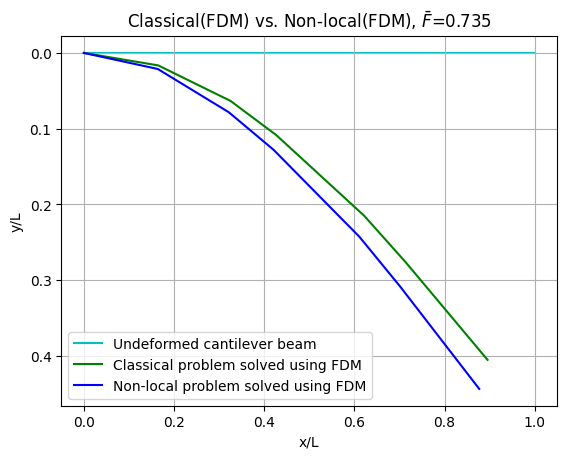

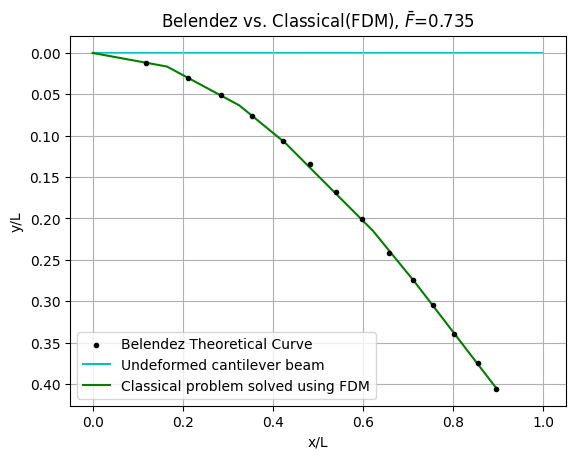

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import csv

# i=n-1 is the last node. So, no. of equations = n

m = 7  #(0 to i=n-1)
delta_s_bar = 1 / (m-1) #non-dimensional


#F_bar=(P*L**2)/(2*E*I)
#P_bar=(P*L**2)/(E*I)


F_bar = 0.735
P_bar = 2 * F_bar
A = P_bar * ((delta_s_bar) ** 2)


def non_local_slopes(a, b):
    def F(x):
        m = len(x)
        x[0], x[1], x[2], *_, x[m-1] = x
        f = [0] * m


        f[0] = x[0]
        f[1] = (a - 2*b) * x[0] - (2*a - 3*b) * x[1] + (a - 2*b) * x[2] + b*x[3] + A * np.cos(x[1])


        for i in range(2, m-2):
            f[i] = b * x[i-2] + (a - 2*b) * x[i-1] - (2*a - 2*b) * x[i] + (a - 2*b) * x[i+1] + b*x[i+2] + A * np.cos(x[i])

        f[m-2] = b * x[m-4] + (a - 2*b) * x[m-3] - (2*a - 3*b) * x[m-2] + (a - 2*b) * x[m-1] + A * np.cos(x[m-2])
        f[m-1] = (3*b/2) * x[m-3] + (2*a - 2*b) * x[m-2] - (2*a - (b/2)) * x[m-1] + A * np.cos(x[m-1])


        f = np.array(f)
        print("Non-local f matrix:")
        print(f)
        return f


    def Jacobian(x):
        m = len(x)
        x[0], x[1], x[2], *_, x[m-1] = x
        J = np.zeros([m, m])


        J[0, 0] = 1


        J[1, 0] = a - 2*b
        J[1, 1] = -(2*a - 3*b) - A * np.sin(x[1])
        J[1, 2] = a - 2*b
        J[1, 3] = b


        for j in range(2, m-2):
            J[j, j-2] = b
            J[j, j-1] = a - 2*b
            J[j, j] = -(2*a - 2*b) - A * np.sin(x[j])
            J[j, j+1] = a - 2*b
            J[j, j+2] = b

        J[m-2, m-4] = b
        J[m-2, m-3] = a - 2*b
        J[m-2, m-2] = -(2*a - 3*b) - A * np.sin(x[m-2])
        J[m-2, m-1] = a - 2*b


        J[m-1, m-3] = (3*b/2)
        J[m-1, m-2] = (2*a - 2*b)
        J[m-1, m-1] = -(2*a - (b/2)) - A * np.sin(x[m-1])


        J = np.array(J)
        print("Non-local Jacobian matrix:")
        print(J)
        return J


    x_guess = np.zeros(m)
    f_values = F(x_guess)
    J_matrix = Jacobian(x_guess)


    def newton_raphson(F, Jacobian, x_guess, max_iter=100, tolerance=1e-6):
        x = x_guess
        for _ in range(max_iter):
            delta_x = np.linalg.solve(Jacobian(x), -F(x))
            x = x + delta_x
            if np.linalg.norm(delta_x) < tolerance:
                break


        return x


    return newton_raphson(F, Jacobian, x_guess)


solution1 = non_local_slopes(a=1, b=0)
solution2 = non_local_slopes(a=0.8, b=0.1)


#vertical deflection  and horizontal deflection calculated from the slope values

upper_l = 1
lower_l = 0


def F_sin(x):
    return math.sin(x)


def F_cos(x):
    return math.cos(x)


def simpsons_rule_integration(F_values):
    n = m - 1
    h = (upper_l - lower_l) / n
    R = np.zeros(m)
    R[0] = 0
    R[1] = (h / 2) * (F_values[0] + F_values[1])

    for i in range(2, m):
        R[i] = ((F_values[0] + F_values[i]) + (4 * np.sum(F_values[1:i:2])) + (2 * np.sum(F_values[2:i:2])))

        R[i] *= (h / 3)

    return R


F1_cos_values = np.array([F_cos(x_val) for x_val in solution1])
x1_values = simpsons_rule_integration(F1_cos_values)
Horizontal_deflection_x1= 1 - x1_values

F1_sin_values = np.array([F_sin(x_val) for x_val in solution1])
y1_values = simpsons_rule_integration(F1_sin_values)


print("Given below are horizontal coordinates for classical problem solved using FDM using large deflection formula :")
for i, result in enumerate(x1_values):
    print("x[{}] = {}".format(i, result))


print("Given below are vertical coordinates for classical problem solved using FDM using large deflection formula :")
for i, result in enumerate(y1_values):
    print("y[{}] = {}".format(i, result))


F2_cos_values = np.array([F_cos(x_val) for x_val in solution2])
x2_values = simpsons_rule_integration(F2_cos_values)
Horizontal_deflection_x2= 1 - x2_values

F2_sin_values = np.array([F_sin(x_val) for x_val in solution2])
y2_values = simpsons_rule_integration(F2_sin_values)


print("Given below are horizontal coordinates for non-local problem solved using FDM using large deflection formula :")
for i, result in enumerate(x2_values):
    print("x[{}] = {}".format(i, result))


print("Given below are vertical coordinates for non-local problem solved using FDM using large deflection formula :")
for i, result in enumerate(y2_values):
    print("y[{}] = {}".format(i, result))


plt.figure()
# Drawing the undeformed cantilever beam
beam_x = np.linspace(0, 1, m)
beam_y = np.zeros_like(beam_x)
plt.plot(beam_x, beam_y, 'c-',linewidth=1.5,label='Undeformed cantilever beam',zorder=1)
plt.plot(x1_values, y1_values, 'g-', linewidth=1.5, label='Classical problem solved using FDM',zorder=2)
plt.plot(x2_values, y2_values, 'b-', linewidth=1.5, label='Non-local problem solved using FDM',zorder=3)
plt.axis='equal'  # Set aspect ratio to 'equal'
plt.xlabel('x/L')
plt.ylabel('y/L')
plt.legend()
plt.title(r'Classical(FDM) vs. Non-local(FDM), $\bar{F}$=0.735')
plt.grid(True)
plt.gca().invert_yaxis()
plt.savefig("Classical FDM VS Non-local,F_bar=0.735,n=7.pdf")
plt.show()




#belendez
# Open the CSV file for reading
csv_file_path = 'Belendez_horizontal_vertical_Fbar=0.735.csv'  # Replace with the actual path to your CSV file
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    # Read values of x and y from each row
    horizontal_values = []
    vertical_values = []
    for row in csv_reader:
        horizontal_values.append(float(row[0]))  # Assuming x is in the first column
        vertical_values.append(float(row[1]))  # Assuming y is in the second column



#table
combined_results = list(zip(Horizontal_deflection_x1,Horizontal_deflection_x2, y1_values,y2_values))
csv_file_path = 'ClassicalFDM,F_bar=0.735,m=7.csv'
with open(csv_file_path, mode='w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Horizontal deflection(Classical-FDM)',
                         'Horizontal deflection(Non-local-FDM)',
                         'Vertical deflection(Classical-FDM)',
                         'Vertical deflection(Non-local-FDM)'])
    csv_writer.writerows(combined_results)



plt.figure()
plt.scatter(horizontal_values, vertical_values,color='k',marker='.',label= 'Belendez Theoretical Curve',zorder=3)
# Drawing the undeformed cantilever beam
beam_x = np.linspace(0, 1, m)
beam_y = np.zeros_like(beam_x)
plt.plot(beam_x, beam_y, 'c-',linewidth=1.5,label='Undeformed cantilever beam',zorder=1)
plt.plot(x1_values, y1_values, 'g-', linewidth=1.5, label='Classical problem solved using FDM',zorder=2)
plt.axis='equal'  # Set aspect ratio to 'equal'
plt.xlabel('x/L')
plt.ylabel('y/L')
plt.legend()
plt.title(r'Belendez vs. Classical(FDM), $\bar{F}$=0.735')
plt.grid(True)
plt.gca().invert_yaxis()
plt.savefig("Graph Belendez comparison,F_bar=0.735,n=7.pdf")
plt.show()